In [1]:
# importing libraries
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import inflect
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import graphviz
import pydotplus
from IPython.display import Image

In [2]:
# functions


# modified stop words so that they are without punctuation
def create_my_stop_words():
    my_stop_words = []       # stop words without punctuation
    for word in stopwords.words("english"): 
        my_word = ""
        for char in word:
            if char not in string.punctuation:
                my_word += char
        my_stop_words.append(my_word)

    other_not_included = ["hed", "itd", "theyd", "youd", "me"] # shed, wed, id are common words but he had, it had, they had, you had
    for word in other_not_included:
        my_stop_words.append(word)
    return my_stop_words


# plural word -> singular word
def singularize_word(word):
    p = inflect.engine()
    singular_word = p.singular_noun(word)
    if singular_word:
        return singular_word
    else:
        return word
    

# prepare dataset
def prepare_kaggle_dataset(df):
    df.fillna("", inplace=True) # filling empty fields
    df["combined"] = df[['Top1', "Top2", "Top3", 'Top4', 'Top5', 'Top6', 'Top7',
      'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
      'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25']].apply(lambda row: " ".join(row), axis=1) # combining all columns into one
    
    new_df = pd.DataFrame(data={"combined": df["combined"], "label": df["Label"]})
    
    return new_df


#test = 0

# text cleaning 
def text_cleanning(row):
    global test
    remove_b = row.replace("b\"", "").replace("b'", "")   # removing b" and b'
    remove_punc = "".join([char for char in remove_b if char not in string.punctuation])     # removing punctuation !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    remove_stop_words = [word for word in remove_punc.split() if word.lower() not in my_stop_words]  # removing stopwords
    


    # comparing different techniques for removing suffixis
    """
    for i in remove_stop_words:
        print(i, " : ", porter_stemmer.stem(i, to_lowercase=False), " : ", lemmatizer.lemmatize(i), " : ", singularize_word(i))
    """
    
    lem_words = [lemmatizer.lemmatize(word) for word in remove_stop_words] # base of the words

    singular_words = [singularize_word(word) for word in lem_words]         # plural -> singular
    #if "me" in singular_words or "Me" in singular_words:
     #   test += 1

    return " ".join(singular_words)  # returning cleaned row as a string


# get each word in Count Vectorizer with its count in 0, 1 and total
def get_word_counts():
    feature_names = tokenizer.get_feature_names_out()

    # Get the indices of the "0" and "1" texts in the DataFrame
    indices_0 = df[df["label"] == 0].index
    indices_1 = df[df["label"] == 1].index

    # Get the occurrences of each word in the "0" texts
    word_counts_0 = tokenized_words[indices_0].sum(axis=0)

    # Get the occurrences of each word in the "1" texts
    word_counts_1 = tokenized_words[indices_1].sum(axis=0)

    # Create a dictionary to store the word counts
    word_counts = {
        "word": feature_names,
        "count_0": word_counts_0.tolist()[0],
        "count_1": word_counts_1.tolist()[0],
    }
    

    # Create a DataFrame from the word counts dictionary
    word_counts_df = pd.DataFrame(word_counts)
    word_counts_df["count"] = word_counts_df["count_0"] + word_counts_df["count_1"]

    return word_counts_df


# printing the prob table
def print_probabilities():
    feature_log_probs = model.feature_log_prob_

    # Convert feature log probabilities to probabilities
    feature_probs = np.exp(feature_log_probs)

    sorted_vocabulary = sorted(tokenizer.vocabulary_.items(), key=lambda x: x[1])

    vocab_arr = [item[0] for item in sorted_vocabulary]

    # Create a DataFrame to represent the probabilistic table
    prob_table = pd.DataFrame(feature_probs, columns=vocab_arr)

    word_counts_df = get_word_counts()  # getting the counts
    word_counts_df.set_index("word", inplace=True)  # making the word column index so it will match the prob_table
    
    prob_table = prob_table.transpose().sort_index()
    prob_table["count"] = word_counts_df["count"]
    prob_table["count_0"] = word_counts_df["count_0"]
    prob_table["count_1"] = word_counts_df["count_1"]
    
    
    #for_csv = prob_table.reset_index()   # adding indexes back
    #for_csv.to_csv("words_for_analysis.csv")
    
    # probability ratio
    prob_table["prob_ratio"] =  prob_table.iloc[:,1] / prob_table.iloc[:, 0]
    
    # product of prob_ratio and count
    prob_table["product_ratio_count"] = prob_table["count"] * prob_table["prob_ratio"]

    # priting the dataframe to a txt file
    with open("output.txt", "w") as f:
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.expand_frame_repr', False)
        #pd.set_option('display.max_colwidth', -1) 

        #print(prob_table.sort_values("pomer",  ascending=False), file=f) # sort by biggest impact on 0
        print(prob_table.sort_values("product_ratio_count", ascending=False), file=f)
        

        pd.reset_option('all')
        

# checking the performance
def my_confusion_matrix(data, predicted_col, true_col, up="up", down="down"):
    tp = data.loc[(data[predicted_col] == up) & (data[true_col] == up)]
    fp = data.loc[(data[predicted_col] == up) & (data[true_col] == down)]
    fn = data.loc[(data[predicted_col] == down) & (data[true_col] == up)]
    tn = data.loc[(data[predicted_col] == down) & (data[true_col] == down)]

    df = pd.DataFrame({"Actual up":[len(tp), len(fn)], "Actual Down":[len(fp), len(tn)]}, index=["Predicted up", "Predicted down"])

    performance = (len(tp) + len(tn)) / (len(tp) + len(tn) + len(fp) + len(fn))
    accuracyP = (len(tp) / (len(tp) + len(fp)))
    
    balance = 0.5*( (len(tp)/(len(tp)+len(fn))) + (len(tn)/(len(tn) + len(fp))))
    
    print("balance:", balance)

    if (len(tn) + len(fn)) == 0:
        accuracyN = "no negatives predicted"
    else:
        accuracyN = (len(tn) / (len(tn) + len(fn)))


    print(df)
    print("Performance: ", performance)
    print("Accuracy Positives: ", accuracyP)
    print("Accuracy Negatives: ", accuracyN)

In [3]:
# Create necessary instances


# tokenizer
#tokenizer = CountVectorizer(analyzer="word", lowercase=False, min_df=10, ngram_range=(1,2)) # ngram_range=(2,2), min_df=4, ngram_range=(1,2)

# tokenizer 2
tokenizer = TfidfVectorizer(analyzer="word", lowercase=False, min_df=10, ngram_range=(1,2))

lemmatizer = WordNetLemmatizer()

my_stop_words = create_my_stop_words()

In [4]:
# load kaggle data
df = pd.read_csv("Combined_News_DJIA.csv")
df = prepare_kaggle_dataset(df)

In [5]:
# load news category data
df_2 = pd.read_csv("news_category_data.csv")

# concatenate
df = pd.concat([df, df_2], ignore_index=True)


# testing
#df = df.head(100)

In [6]:
# clean each row + asigning numbers to words
df["combined"] = df['combined'].apply(text_cleanning)
#print(test)
tokenized_words = tokenizer.fit_transform(df["combined"])      

In [7]:
# spliting data into training and testing date sets
X_train, X_test, y_train, y_test = train_test_split(tokenized_words, df["label"], test_size=0.1,shuffle=True, random_state=42) #

In [81]:
# Over fitting label?
print(df["label"].value_counts())  # value counts before

undersampler = RandomUnderSampler(random_state=42)

X_train, y_train = undersampler.fit_resample(X_train, y_train)
print(y_train.value_counts())  # value counts after


1    2433
0    1937
Name: label, dtype: int64
0    1760
1    1760
Name: label, dtype: int64


balance: 0.4688663101604278
                Actual up  Actual Down
Predicted up          197          159
Predicted down         53           28
Performance:  0.5148741418764302
Accuracy Positives:  0.5533707865168539
Accuracy Negatives:  0.345679012345679


[Text(0.7, 0.9166666666666666, 'Bannon <= 0.079\ngini = 0.494\nsamples = 3933\nvalue = [1750, 2183]'),
 Text(0.65, 0.75, 'Iran <= 0.118\ngini = 0.495\nsamples = 3909\nvalue = [1750, 2159]'),
 Text(0.4, 0.5833333333333334, 'million <= 0.025\ngini = 0.494\nsamples = 3871\nvalue = [1720, 2151]'),
 Text(0.2, 0.4166666666666667, 'Guy <= 0.035\ngini = 0.49\nsamples = 3114\nvalue = [1334, 1780]'),
 Text(0.1, 0.25, 'Judge <= 0.029\ngini = 0.488\nsamples = 3060\nvalue = [1297, 1763]'),
 Text(0.05, 0.08333333333333333, 'gini = 0.491\nsamples = 2894\nvalue = [1253, 1641]'),
 Text(0.15, 0.08333333333333333, 'gini = 0.39\nsamples = 166\nvalue = [44, 122]'),
 Text(0.3, 0.25, 'ago <= 0.026\ngini = 0.431\nsamples = 54\nvalue = [37, 17]'),
 Text(0.25, 0.08333333333333333, 'gini = 0.359\nsamples = 47\nvalue = [36, 11]'),
 Text(0.35, 0.08333333333333333, 'gini = 0.245\nsamples = 7\nvalue = [1, 6]'),
 Text(0.6, 0.4166666666666667, 'Justice <= 0.038\ngini = 0.5\nsamples = 757\nvalue = [386, 371]'),
 Text(0

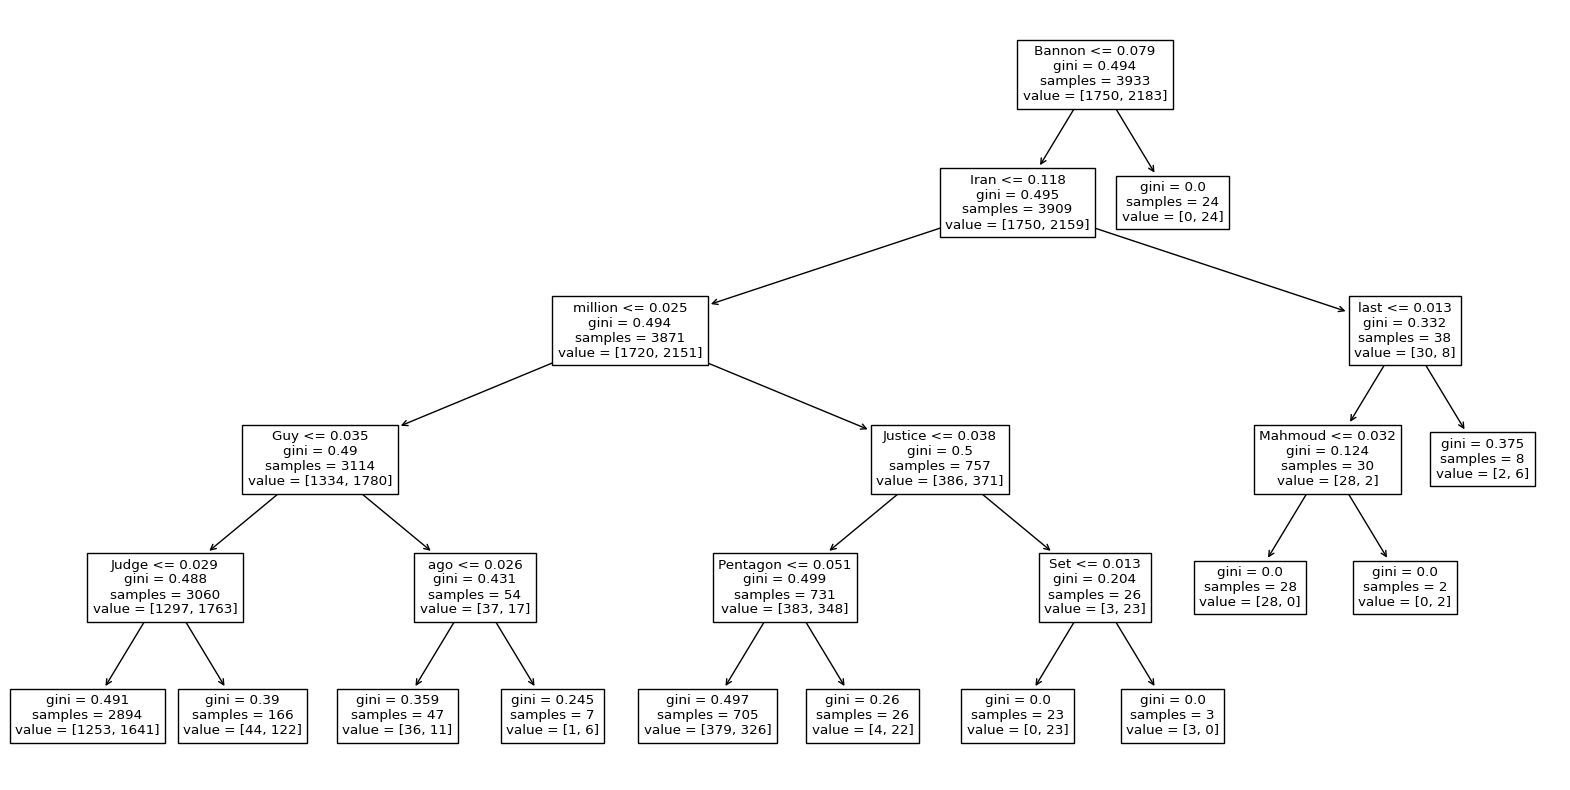

In [15]:
# DecisionTree
model = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=10)
model.fit(X_train, y_train)


# making predictions for testing
predict = model.predict(X_test)

# printing the confusion matrix
conf = pd.DataFrame({"Predicted": predict, "Actual":y_test})
my_confusion_matrix(conf, "Predicted", "Actual", up=1, down=0)


feature_names = tokenizer.get_feature_names_out().tolist()

plt.figure(figsize=(20, 10))
tree.plot_tree(model,feature_names=feature_names) # 

In [109]:
# LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

# making predictions for testing
predict = model.predict(X_test)

# printing the confusion matrix
conf = pd.DataFrame({"Predicted": predict, "Actual":y_test})
my_confusion_matrix(conf, "Predicted", "Actual", up=1, down=0)

balance: 0.4715614973262032
                Actual up  Actual Down
Predicted up          193          155
Predicted down         57           32
Performance:  0.5148741418764302
Accuracy Positives:  0.5545977011494253
Accuracy Negatives:  0.3595505617977528


In [110]:
# RandomForesest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# making predictions for testing
predict = model.predict(X_test)

# printing the confusion matrix
conf = pd.DataFrame({"Predicted": predict, "Actual":y_test})
my_confusion_matrix(conf, "Predicted", "Actual", up=1, down=0)

balance: 0.49366844919786096
                Actual up  Actual Down
Predicted up          184          140
Predicted down         66           47
Performance:  0.528604118993135
Accuracy Positives:  0.5679012345679012
Accuracy Negatives:  0.415929203539823


In [111]:
# SupportVectorMachine
model = SVC()
model.fit(X_train, y_train)

# making predictions for testing
predict = model.predict(X_test)

# printing the confusion matrix
conf = pd.DataFrame({"Predicted": predict, "Actual":y_test})
my_confusion_matrix(conf, "Predicted", "Actual", up=1, down=0)

balance: 0.5054545454545455
                Actual up  Actual Down
Predicted up          230          170
Predicted down         20           17
Performance:  0.5652173913043478
Accuracy Positives:  0.575
Accuracy Negatives:  0.4594594594594595


In [112]:
# Naive Bayes
# creating the model and fitting the data
model = MultinomialNB(alpha=0.1, fit_prior=False)
model.fit(X_train, y_train)

# making predictions for testing
predict = model.predict(X_test)

# printing the confusion matrix
conf = pd.DataFrame({"Predicted": predict, "Actual":y_test})
my_confusion_matrix(conf, "Predicted", "Actual", up=1, down=0)

balance: 0.46257754010695185
                Actual up  Actual Down
Predicted up          123          106
Predicted down        127           81
Performance:  0.4668192219679634
Accuracy Positives:  0.537117903930131
Accuracy Negatives:  0.3894230769230769


In [9]:
# print the probabilities to output.txt
print_probabilities()

/var/folders/1_/_85l6zx17ybc3xvtmwp5p49c0000gn/T/ipykernel_3990/2382375518.py:142: FutureWarning: column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.
  pd.reset_option('all')
/var/folders/1_/_85l6zx17ybc3xvtmwp5p49c0000gn/T/ipykernel_3990/2382375518.py:142: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  pd.reset_option('all')
/var/folders/1_/_85l6zx17ybc3xvtmwp5p49c0000gn/T/ipykernel_3990/2382375518.py:142: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  pd.reset_option('all')
